In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import relabel_image_stardist3D, Rays_GoldenSpiral, calculate_extents
from stardist import fill_label_holes, random_label_cmap
from stardist.matching import matching_dataset

np.random.seed(42)
lbl_cmap = random_label_cmap()

# Data

This notebook demonstrates how the training data for *StarDist* should look like and whether the annotated objects can be appropriately described by star-convex polyhedra. 

<div class="alert alert-block alert-info">
The training data that needs to be provided for StarDist consists of corresponding pairs of raw images and pixelwise annotated ground truth images (masks), where every pixel has a unique integer value indicating the object id (or 0 for background). 
</div>

For this demo we will download the file file `demo3D.zip` that contains synthetic train and test images with associated ground truth labels.

In [2]:
#download_and_extract_zip_file(
#    url       = 'https://github.com/mpicbg-csbd/stardist/releases/download/0.3.0/demo3D.zip',
#    targetdir = 'data',
#    verbose   = 1,
#)

In [3]:
X = sorted(glob('data/train/images/*.tif'))
Y = sorted(glob('data/train/masks/*.tif'))
print(X)
#assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

['data/train/images\\C1-zone1Area1_images-sub1.tif', 'data/train/images\\C1-zone1Area1_images-sub2.tif', 'data/train/images\\C1-zone1Area1_images-sub3.tif', 'data/train/images\\C1-zone1Area2_images.tif']


Load only a small subset.

In [4]:
X, Y = X[:10], Y[:10]
print(X)

['data/train/images\\C1-zone1Area1_images-sub1.tif', 'data/train/images\\C1-zone1Area1_images-sub2.tif', 'data/train/images\\C1-zone1Area1_images-sub3.tif', 'data/train/images\\C1-zone1Area2_images.tif']


In [5]:
X = list(map(imread,X))
Y = list(map(imread,Y))
print(len(X))
print(len(Y))

4
4


In [6]:
extents = calculate_extents(Y)
print(str(extents))
anisotropyexpe = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropyexpe))
anisotropygiven=(10,10,10)
print('given anisotropy of labeled objects = %s' % str(anisotropygiven))

[ 6.5  50.75 45.5 ]
empirical anisotropy of labeled objects = (7.8076923076923075, 1.0, 1.1153846153846154)
given anisotropy of labeled objects = (10, 10, 10)


# Example image

In [7]:
i = 0
img, lbl = X[i], fill_label_holes(Y[i])
assert img.ndim in (3,4)
# assumed axes ordering of img and lbl is: ZYX(C)

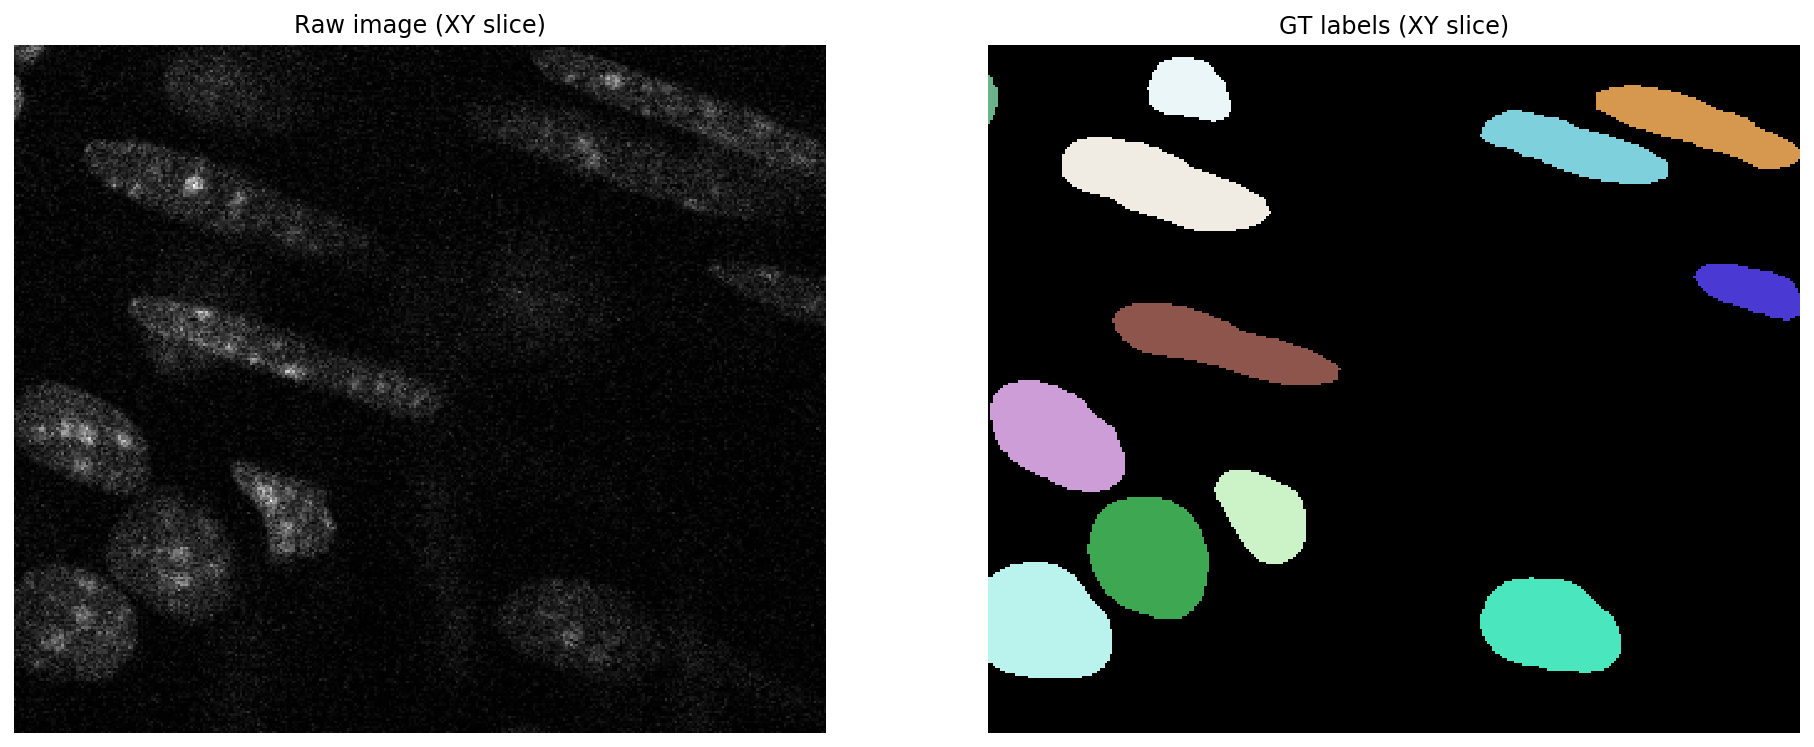

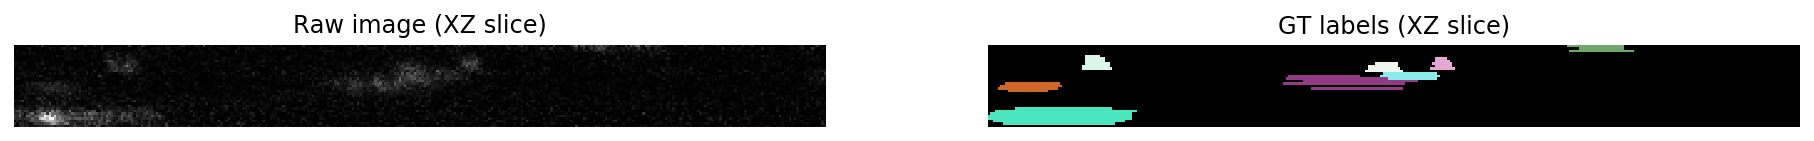

In [8]:
plt.figure(figsize=(16,10))
z = img.shape[0] // 2
y = img.shape[1] // 2
plt.subplot(121); plt.imshow(img[z],cmap='gray');   plt.axis('off'); plt.title('Raw image (XY slice)')
plt.subplot(122); plt.imshow(lbl[z],cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels (XY slice)')
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img[:,y],cmap='gray');   plt.axis('off'); plt.title('Raw image (XZ slice)')
plt.subplot(122); plt.imshow(lbl[:,y],cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels (XZ slice)')
None;

# Fitting ground-truth labels with star-convex polyhedra

In [9]:
help(Rays_GoldenSpiral)

Help on class Rays_GoldenSpiral in module stardist.rays3d:

class Rays_GoldenSpiral(Rays_Base)
 |  Rays_GoldenSpiral(n=70, anisotropy=None)
 |  
 |  Method resolution order:
 |      Rays_GoldenSpiral
 |      Rays_Base
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, n=70, anisotropy=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  setup_vertices_faces(self)
 |      has to return
 |      
 |      verts , faces
 |      
 |      verts = ( (z_1,y_1,x_1), ... )
 |      faces ( (0,1,2), (2,3,4), ... )
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Rays_Base:
 |  
 |  __getitem__(self, i)
 |  
 |  __len__(self)
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  dist_loss_weights(self, anisotropy=(1, 1, 1))
 |      returns the anisotropy corrected weights for each ray
 |  
 |  to_json(self)
 |  
 |  -------------------------------------------------------------

In [10]:
def reconstruction_scores(n_rays, anisotropy):
    scores = []
    for r in tqdm(n_rays):
        rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
        Y_reconstructed = [relabel_image_stardist3D(lbl, rays) for lbl in Y]
        mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
        scores.append(mean_iou)
    return scores

In [21]:
n_rays = [8, 16, 32, 64, 96, 128]
#n_rays=[32]
#scores_iso   = reconstruction_scores(n_rays, anisotropy=None)
scores_aniso = reconstruction_scores(n_rays, anisotropy=anisotropyexpe)
#scores_anisogiven = reconstruction_scores(n_rays, anisotropy=anisotropygiven)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:02<00:00, 30.48s/it]


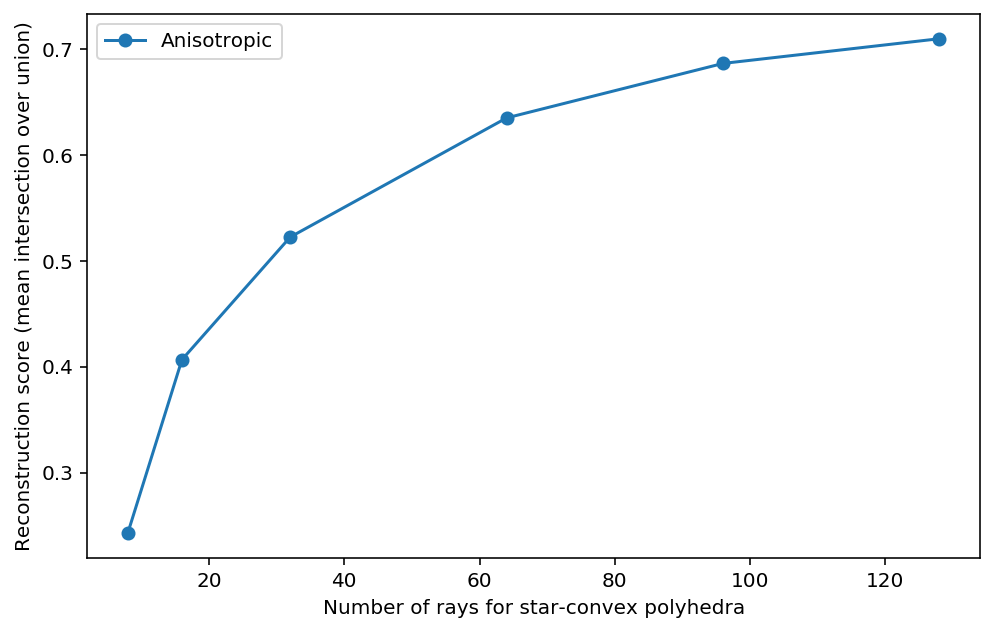

In [22]:
plt.figure(figsize=(8,5))
#plt.plot(n_rays, scores_iso,   'o-', label='Isotropic')
plt.plot(n_rays, scores_aniso, 'o-', label='Anisotropic')
#plt.plot(n_rays, scores_anisogiven, 'o-', label='Anisotropic using calibration')
plt.xlabel('Number of rays for star-convex polyhedra')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.legend()
None;

# Example image reconstructed with various number of rays

## Taking anisotropy into account

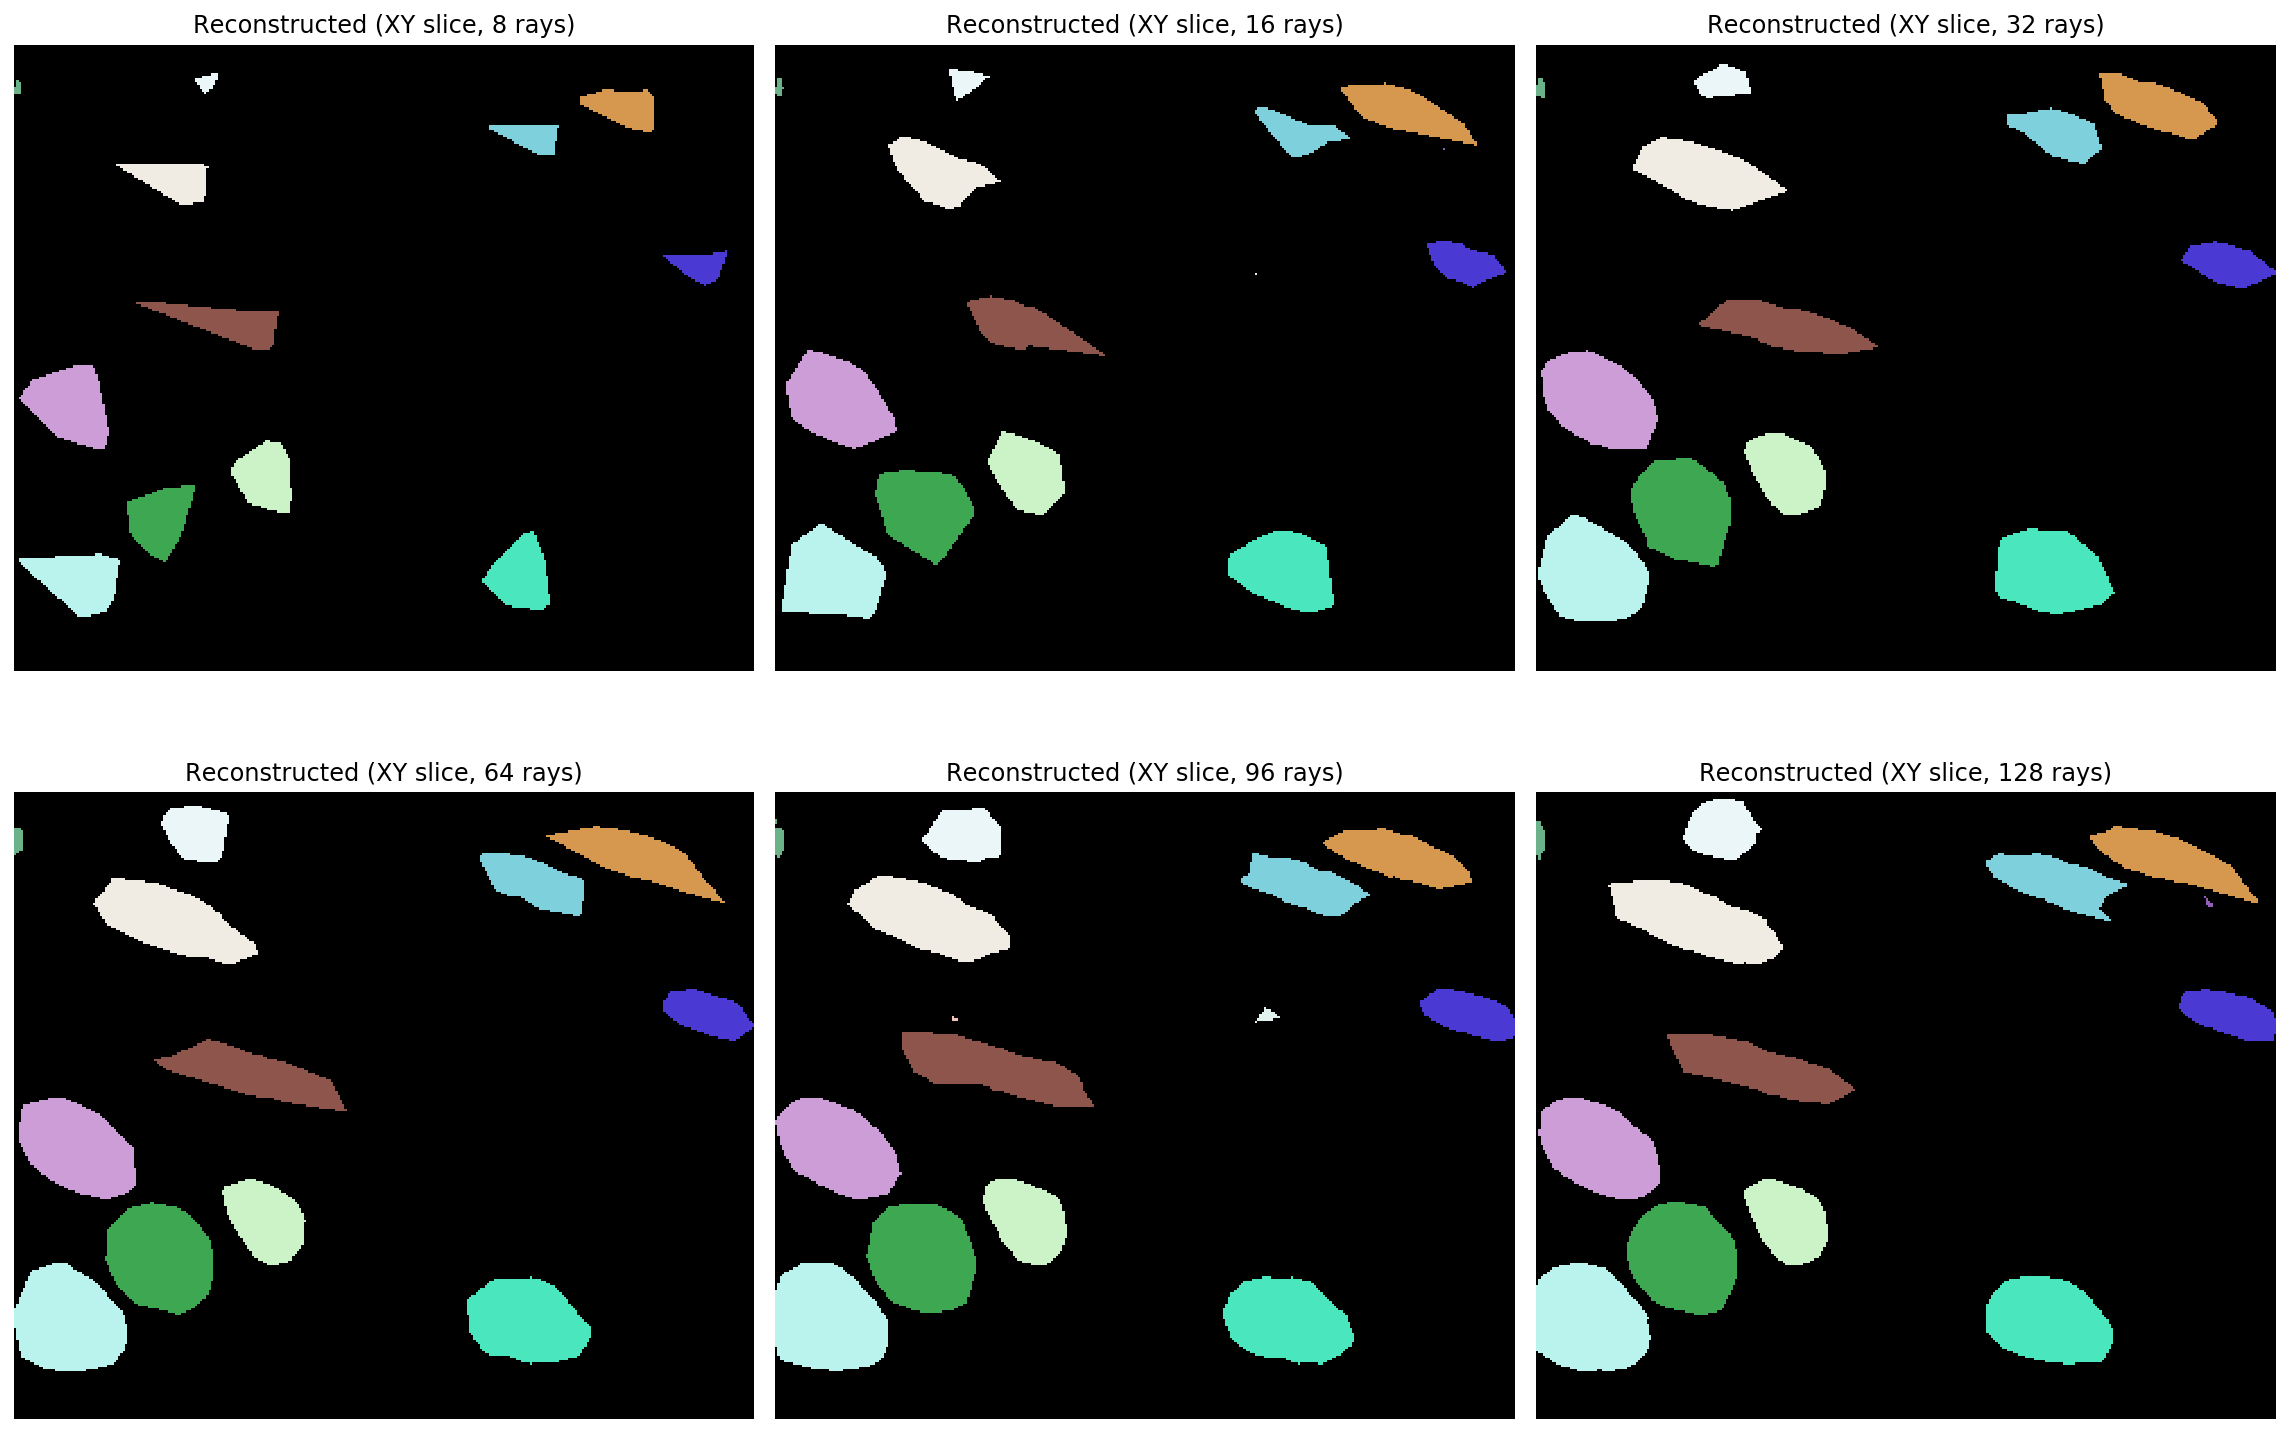

In [23]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    z = lbl.shape[0] // 2
    rays = Rays_GoldenSpiral(r, anisotropy=anisotropyexpe)
    a.imshow(relabel_image_stardist3D(lbl, rays)[z], cmap=lbl_cmap)
    a.set_title('Reconstructed (XY slice, %d rays)' % r)
    a.axis('off')
plt.tight_layout();

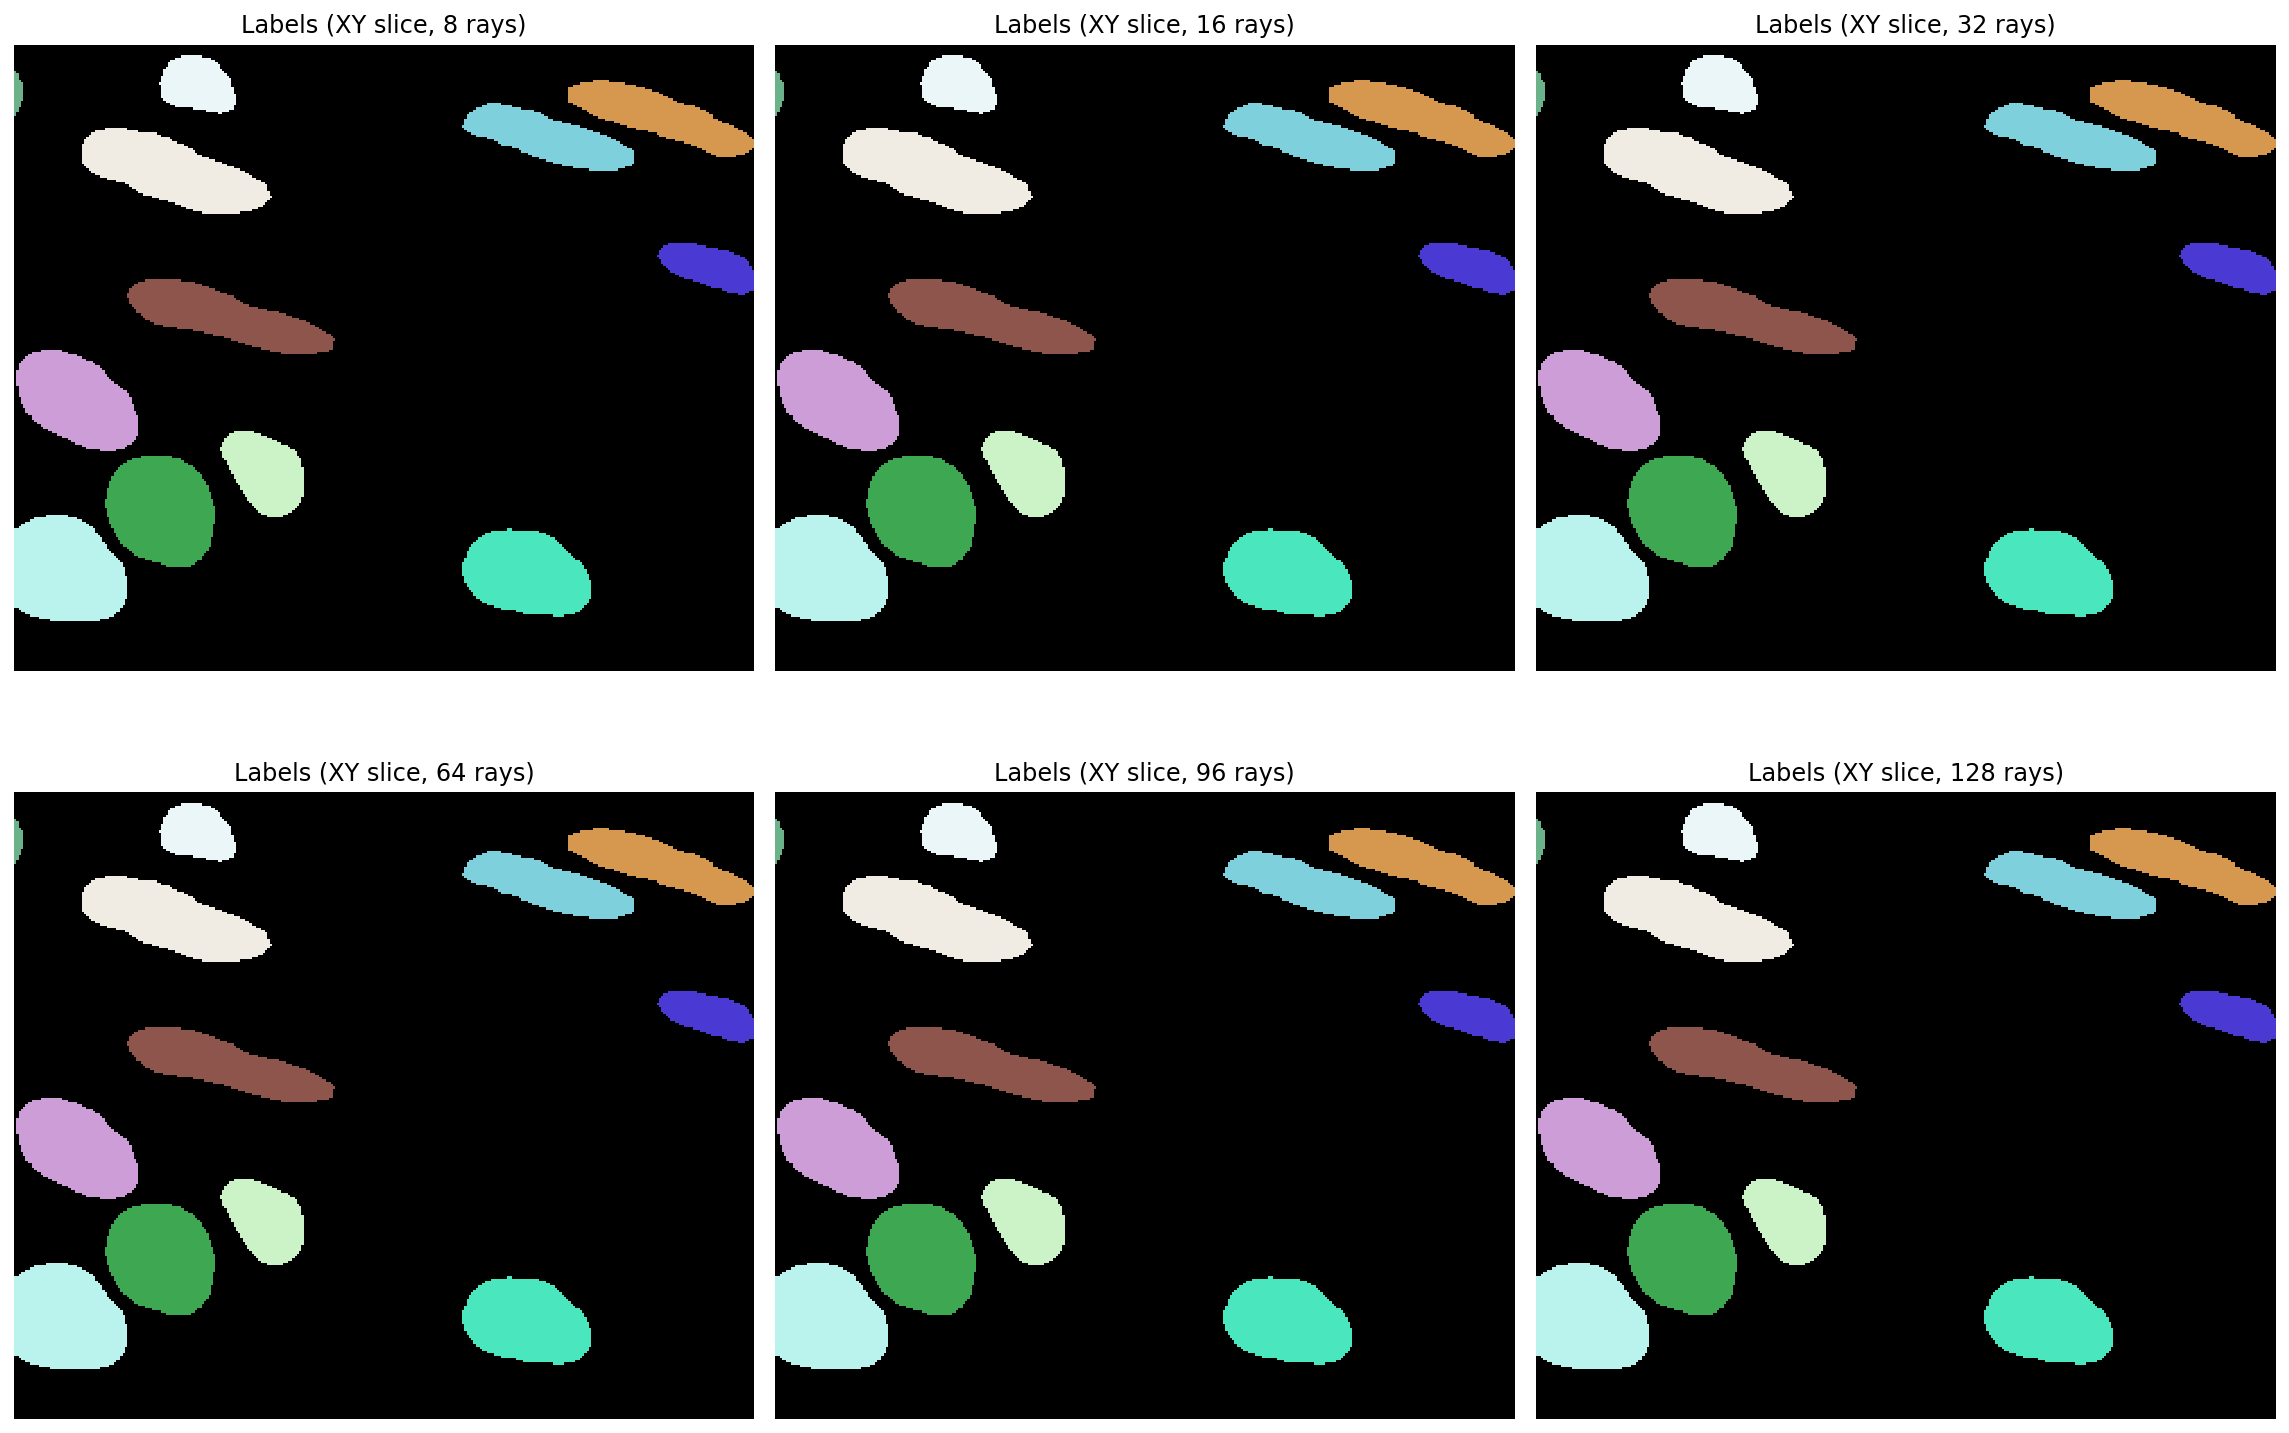

In [24]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    z = lbl.shape[0] // 2
    a.imshow(lbl[z],cmap=lbl_cmap)
    a.set_title('Labels (XY slice, %d rays)' % r)
    a.axis('off')
plt.tight_layout();

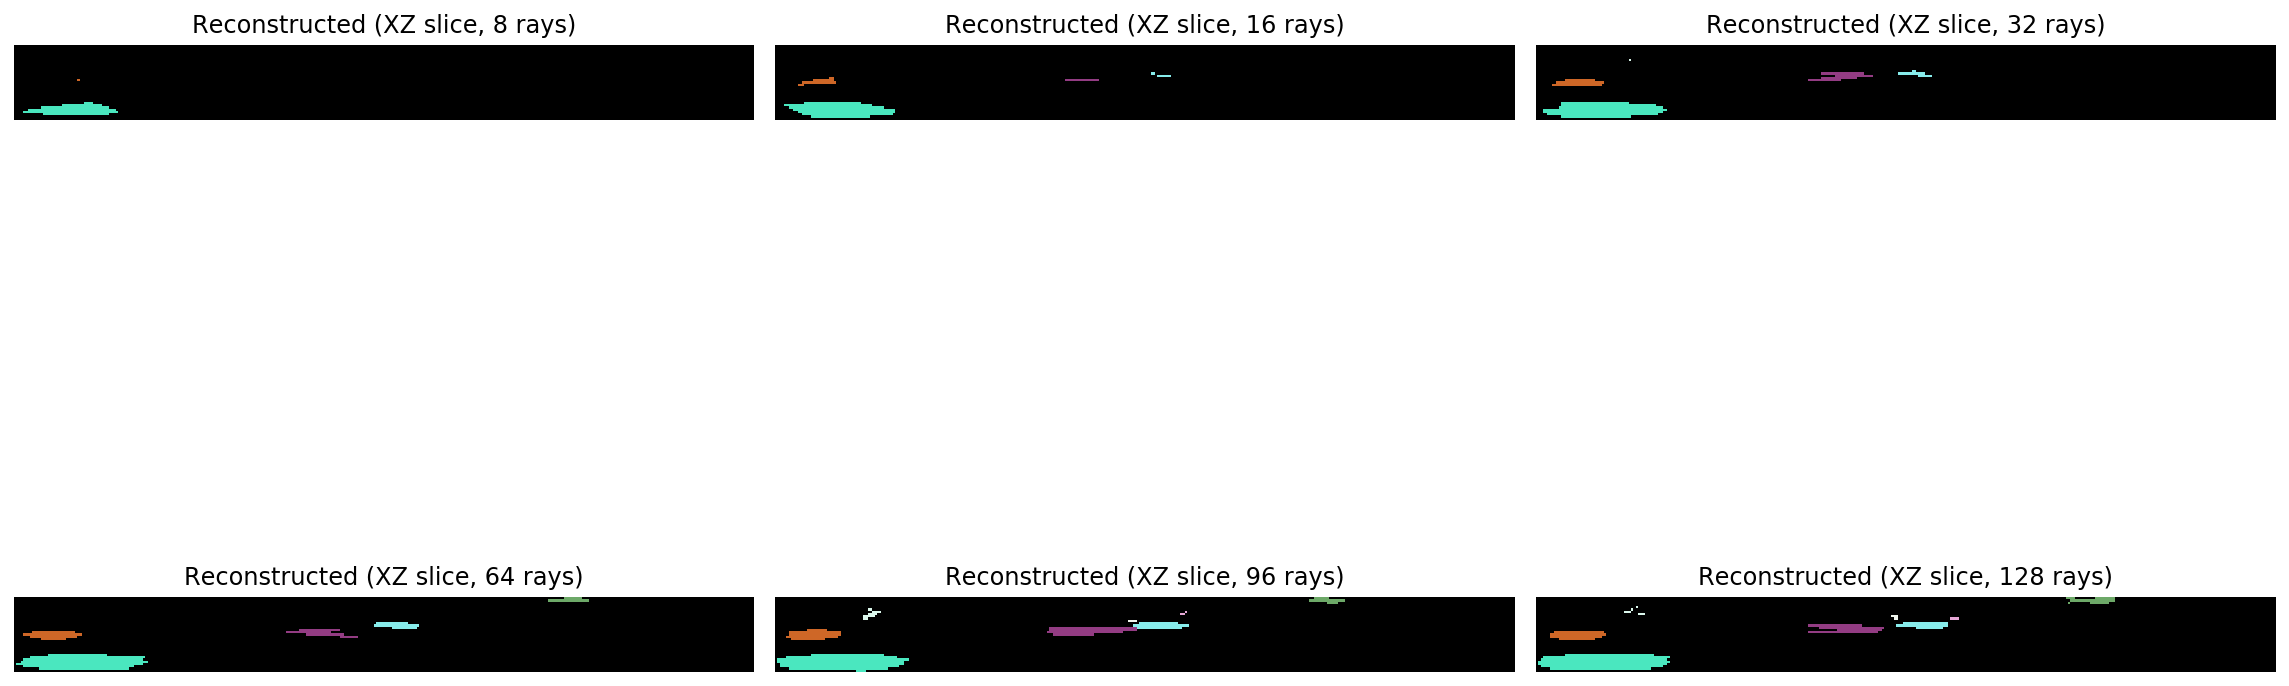

In [25]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    z = lbl.shape[0] // 2
    rays = Rays_GoldenSpiral(r, anisotropy=anisotropyexpe)
    a.imshow(relabel_image_stardist3D(lbl, rays)[:,y], cmap=lbl_cmap)
    a.set_title('Reconstructed (XZ slice, %d rays)' % r)
    a.axis('off')
    
plt.tight_layout();

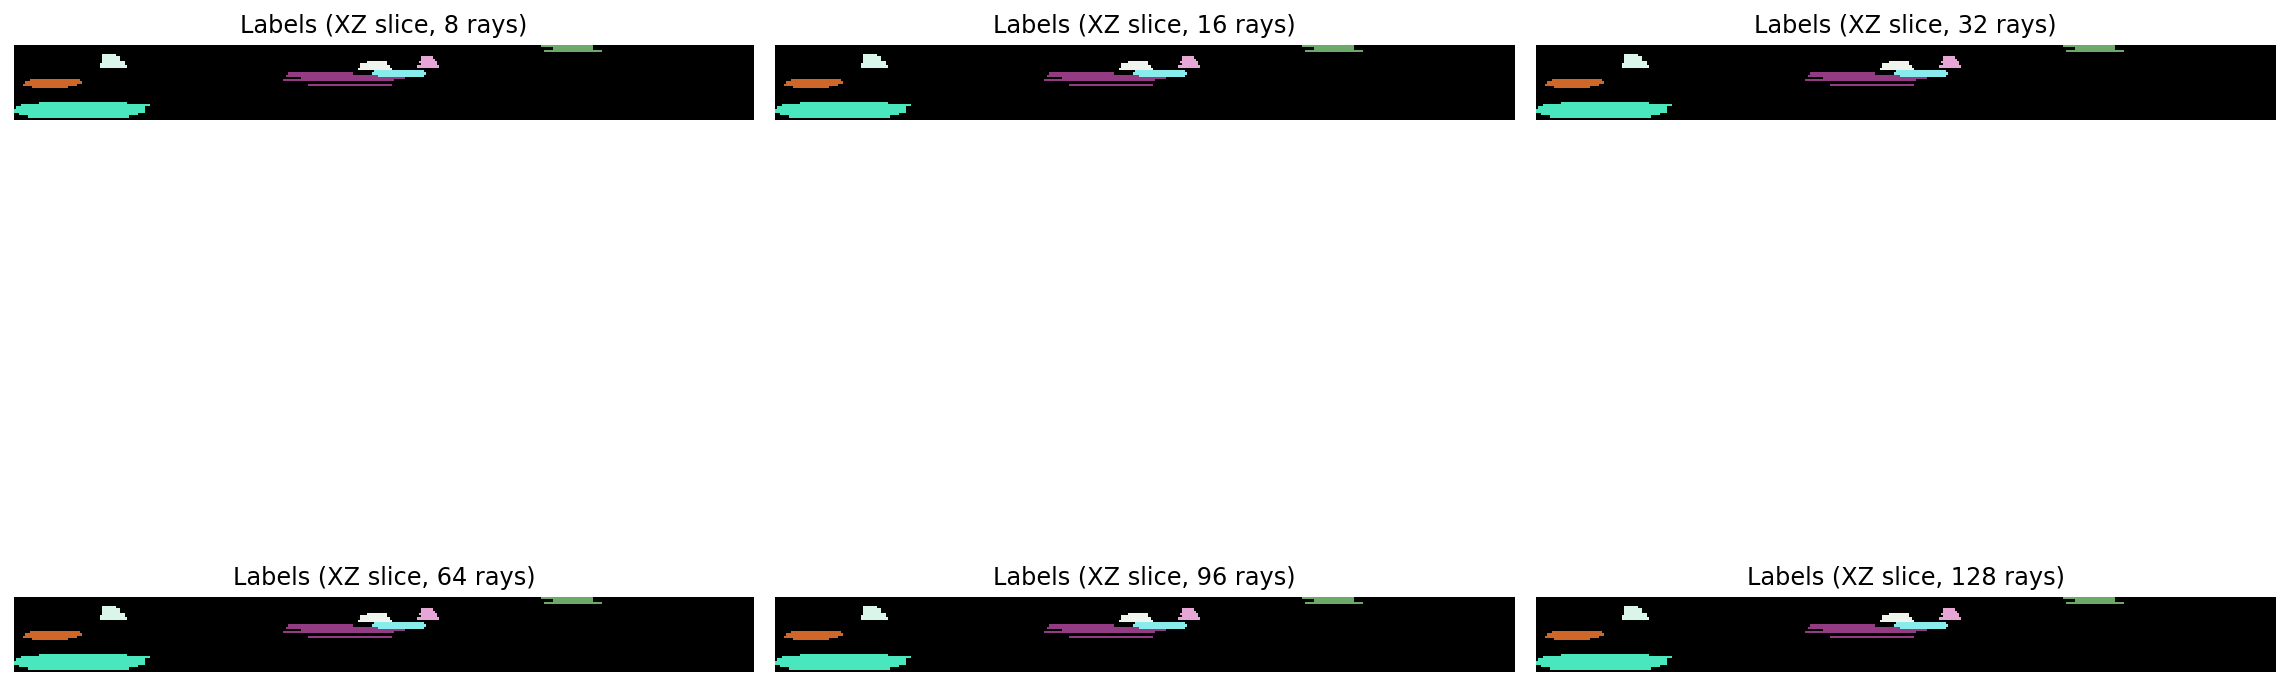

In [26]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    z = lbl.shape[0] // 2
    a.imshow(lbl[:,y],cmap=lbl_cmap)
    a.set_title('Labels (XZ slice, %d rays)' % r)
    a.axis('off')
plt.tight_layout();